<a href="https://colab.research.google.com/github/kim1987/aiffel/blob/main/aiffel/deeper/dp_eight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GD_8  
https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html  
https://github.com/huggingface/transformers/tree/v4.15.0  
https://github.com/SKTBrain/KoBERT/tree/master/kobert_hf

In [1]:
!python3 -m pip install konlpy  

In [2]:
!sudo apt-get install curl git
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.58.0-2ubuntu3.16).
git is already the newest version (1:2.17.1-1ubuntu0.9).
0 upgraded, 0 newly installed, 0 to remove and 85 not upgraded.
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [3]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.test.tar.gz
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.dev.tar.gz

--2021-12-24 01:15:29--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2021-12-24 01:15:30--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz.1’

korean-e

In [4]:
!pip install transformers

In [5]:
!mkdir data
!tar -zxvf ./korean-english-park.dev.tar.gz -C ./data
!tar -zxvf ./korean-english-park.test.tar.gz -C ./data
!tar -zxvf ./korean-english-park.train.tar.gz -C ./data

mkdir: cannot create directory ‘data’: File exists
korean-english-park.dev.en
korean-english-park.dev.ko
korean-english-park.test.en
korean-english-park.test.ko
korean-english-park.train.en
korean-english-park.train.ko


In [6]:
!pip install sentencepiece

In [7]:
!pip install transformers

In [8]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-wsbss5b7/kobert-tokenizer_35530deacd094ac8ab482b156e5935d4
  Running command git clone -q https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-wsbss5b7/kobert-tokenizer_35530deacd094ac8ab482b156e5935d4


In [9]:
from konlpy.tag import Mecab
import numpy as np
import torch
import torchtext
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import torch.nn as nn
from torch import optim
import random
from tqdm.notebook import tqdm

In [10]:
from transformers import XLNetTokenizer
from kobert_tokenizer import KoBERTTokenizer

In [136]:
!pip install torchinfo

In [137]:
from torchinfo import summary

데이터 불러오기 및 전처리

In [94]:
txt_train_en = pd.read_fwf('/content/data/korean-english-park.train.en',header=None,names=['english'],encoding='utf-8',delimiter='\n')
txt_train_ko = pd.read_fwf('/content/data/korean-english-park.train.ko',header=None,names=['korean'],encoding='utf-8',delimiter='\n')

txt_test_en = pd.read_fwf('/content/data/korean-english-park.test.en',header=None,names=['english'],encoding='utf-8',delimiter='\n')
txt_test_ko = pd.read_fwf('/content/data/korean-english-park.test.ko',header=None,names=['korean'],encoding='utf-8',delimiter='\n')

In [95]:
txt_train = pd.concat([txt_train_ko,txt_train_en],axis=1)
txt_test = pd.concat([txt_test_ko,txt_test_en],axis=1)

In [9]:
#mecab = Mecab()

#txt_train = txt_train.applymap(lambda x :mecab.morphs(x) + ['[EOS]'])
#txt_test = txt_test.applymap(lambda x :mecab.morphs(x) + ['[EOS]'])


In [96]:
print(txt_train.applymap(len).max(),'\n')
print(txt_test.applymap(len).max())

korean     162
english    258
dtype: int64 

korean     130
english    241
dtype: int64


In [97]:
max_len = 20

In [98]:
txt_train = txt_train[(txt_train['korean'].apply(len)<=max_len) & (txt_train['english'].apply(len)<=max_len*2)]
txt_test = txt_test[(txt_test['korean'].apply(len)<=max_len) & (txt_test['english'].apply(len)<=max_len*2)]

In [13]:
#vocab_ko = torchtext.vocab.build_vocab_from_iterator(txt_train['korean'],specials=['[PAD]','[UNK]','[BOS]','[EOS]'],min_freq=1)
#vocab_ko.set_default_index(vocab_ko["[UNK]"])
#vocab_en = torchtext.vocab.build_vocab_from_iterator(txt_train['english'],specials=['[PAD]','[UNK]','[BOS]','[EOS]'],min_freq=1)
#vocab_en.set_default_index(vocab_en["[UNK]"])

In [36]:
ko_tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
en_tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [15]:
PAD_IDX = 0

In [16]:
#SOS_token = vocab_ko['[BOS]']
#EOS_token = vocab_ko['[EOS]']

In [99]:
#txt_train['korean']=txt_train['korean'].apply(vocab_ko)
#txt_train['english']=txt_train['english'].apply(lambda x : vocab_en(x))
#txt_test['korean']=txt_test['korean'].apply(vocab_ko)
#txt_test['english']=txt_test['english'].apply(lambda x : vocab_en(x))
txt_train['korean']=txt_train['korean'].apply(ko_tokenizer.encode)
txt_train['english']=txt_train['english'].apply(en_tokenizer.encode)
txt_test['korean']=txt_test['korean'].apply(ko_tokenizer.encode)
txt_test['english']=txt_test['english'].apply(en_tokenizer.encode)

In [100]:
print(txt_train.applymap(len).max(),'\n')
print(txt_test.applymap(len).max(),'\n')
print(len(txt_train))

korean     20
english    21
dtype: int64 

korean     16
english    23
dtype: int64 

6822


In [39]:
max_len = 21

In [18]:
#torch.nn.functional.pad(torch.tensor(txt_train['korean'][0]), (PAD_IDX, max_len)) # -> 이방법으로 dataset,loader 할때 변환가능.

In [19]:
#train_ko = tf.keras.preprocessing.sequence.pad_sequences(txt_train['korean'], padding='post',maxlen = max_len,value = PAD_IDX)
#train_en = tf.keras.preprocessing.sequence.pad_sequences(txt_train['english'], padding='post',maxlen = max_len,value = PAD_IDX)
#test_ko = tf.keras.preprocessing.sequence.pad_sequences(txt_test['korean'], padding='post',maxlen = max_len,value = PAD_IDX)
#test_en = tf.keras.preprocessing.sequence.pad_sequences(txt_test['english'], padding='post',maxlen = max_len,value = PAD_IDX)

In [101]:
train_ko = txt_train['korean'].to_numpy()
train_en = txt_train['english'].to_numpy()
test_ko = txt_test['korean'].to_numpy()
test_en = txt_test['english'].to_numpy()

In [102]:
vocab_size_ko = len(ko_tokenizer)
vocab_size_en = len(en_tokenizer)

In [103]:
class MyDataSet(torch.utils.data.Dataset):

  def __init__(self,train=True):
      self.data_ko = train_ko if train else test_ko
      self.data_en = train_en if train else test_en

  def __len__(self):
    return len(self.data_ko)

  def __getitem__(self,idx):
    return torch.tensor(self.data_ko[idx],dtype=torch.long),torch.tensor(self.data_en[idx],dtype=torch.long)

In [104]:
data_train = MyDataSet()
data_test = MyDataSet(train=False)
load_train = torch.utils.data.DataLoader(data_train,shuffle=True,batch_size=1,num_workers=2)
load_test = torch.utils.data.DataLoader(data_test,shuffle=True,batch_size=1,num_workers=2)

In [160]:
data_train[0]

(tensor([   2, 1567,  605, 6208, 3129, 5859, 3051, 5899, 2680, 7100,   54,    3]),
 tensor([3206,  538,   41,  194, 2279,    9,    4,    3]))

In [163]:
print(ko_tokenizer.decode(data_train[0][0]))
print(en_tokenizer.decode(data_train[0][1]))

[CLS] 다른 4명은 아직도 실종된 상태이다.[SEP]
Four others are still missing.<sep><cls>


패딩처리를 안했기 때문에 배치사이즈1.

모델 생성.  


In [47]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(torch.cuda.get_device_name())

Tesla V100-SXM2-16GB


In [71]:
PAD_IDX = ko_tokenizer.pad_token_id
EOS_token_id = ko_tokenizer.eos_token_id
SOS_token_id = en_tokenizer.bos_token_id

In [48]:
class MyEncoder(nn.Module):

  def __init__(self,hidden_size,vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(num_embeddings = vocab_size_ko,embedding_dim=hidden_size,padding_idx = PAD_IDX)
    self.gru = nn.GRU(input_size=hidden_size,hidden_size=hidden_size,dropout=0.2,batch_first=True)

  def forward(self,inputs):
    x = self.embedding(inputs)
    output,hidden = self.gru(x)
    return output,hidden

In [49]:
class MyDecoder(nn.Module):

  def __init__(self,hidden_size,vocab_size,dropout_p=0.1, max_length=max_len):
    super().__init__()
    self.max_len=max_len
    self.w_s = nn.Linear(hidden_size,hidden_size)
    self.w_h = nn.Linear(hidden_size,hidden_size)
    self.w_v = nn.Linear(hidden_size,1)
    self.attn = nn.Linear(hidden_size*2,hidden_size)

    self.emb = nn.Embedding(num_embeddings = vocab_size_en,embedding_dim=hidden_size,padding_idx = PAD_IDX)
    self.gru = nn.GRU(input_size=hidden_size,hidden_size=hidden_size,dropout=0.2,batch_first=True)

    self.fc = nn.Linear(hidden_size,vocab_size)

  def forward(self,inputs,hidden,output_en):
    embedded = self.emb(inputs)
    s_tm = hidden.squeeze(0).unsqueeze(1)
    h_tm = output_en

    score = self.w_v(torch.tanh(self.w_s(s_tm)+self.w_h(h_tm)))
    attn_weight = nn.Softmax(dim=1)(score)
    context_vector = torch.sum(attn_weight*h_tm,dim=1) #batch,len,hidden ->batch,hidden
    x = self.attn(torch.cat([context_vector.unsqueeze(0),embedded],dim=-1))

    output, hidden = self.gru(x,hidden)
    output = self.fc(output)
    output = nn.functional.log_softmax(output,dim=-1)
    return output, hidden, attn_weight

In [50]:
class AttnDecoderRNN(nn.Module): # pytorch decoder
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_len):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = nn.functional.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = nn.functional.relu(output)
        output, hidden = self.gru(output, hidden)

        output = nn.functional.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [61]:
def ko_to_ten(input):
  return torch.tensor(ko_tokenizer.encode(input+' [EOS]'))
def ten_to_en(input):
  return en_tokenizer.decode(input)

In [69]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, hidden_size, max_length=max_len):
    encoder.train()
    decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)

    encoder_outputs = torch.zeros(max_length, hidden_size, device=device)

    loss = 0

    encoder_output, encoder_hidden = encoder(
        input_tensor)

    decoder_input = torch.tensor([[SOS_token_id]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output.squeeze(0), target_tensor[0][di].unsqueeze(0))#criterion(decoder_output, target_tensor[0][di].unsqueeze(0))
            decoder_input = target_tensor[0][di].view(1,-1)

    else:
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output.squeeze(0), target_tensor[0][di].unsqueeze(0))#criterion(decoder_output, target_tensor[0][di].unsqueeze(0))
            decoder_input = torch.argmax(decoder_output,dim=-1)
            if torch.argmax(decoder_output.detach(),dim=-1).squeeze() == EOS_token_id:
                break
    loss = loss / target_length
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.item() / target_length

In [53]:
%matplotlib inline
def trainIters(encoder, decoder,num_sen,n_iters, hidden_size, print_every=1000, plot_every=100, learning_rate=0.002):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
      load_train = torch.utils.data.DataLoader(data_train,shuffle=True,batch_size=1,num_workers=2)
      for idx, data in enumerate(tqdm(load_train,total = num_sen)):
          input_tensor = data[0]
          target_tensor = data[1]

          loss = train(input_tensor.to(device), target_tensor.to(device), encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion,hidden_size)
          print_loss_total += loss
          plot_loss_total += loss

          if idx % print_every == 0 and idx !=0 :
              print_loss_avg = print_loss_total / print_every
              print_loss_total = 0
              sentence = '모델에 문제가 없으면 전처리에 집중해야한다.'
              test = test_trans(encoder1, attn_decoder1, sentence,hidden_size)
              print('\r',print_loss_avg,test,end='')

          if idx % plot_every == 0  and idx !=0 :
              plot_loss_avg = plot_loss_total / plot_every
              plot_losses.append(plot_loss_avg)
              plot_loss_total = 0

          if idx >= num_sen:
            break
    #showPlot(plot_losses)
    plt.plot(plot_losses)
    return plot_losses

In [54]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [90]:
def test_trans(encoder, decoder, sentence, hidden_size, max_length=max_len):
    with torch.no_grad():
      
        encoder.eval()
        decoder.eval()
        input_tensor = ko_to_ten(sentence)
        input_length = input_tensor.size()[0]

        
        encoder_outputs = torch.zeros(max_length, hidden_size, device=device)

        
        encoder_output, encoder_hidden = encoder(input_tensor.unsqueeze(0).to(device))

        decoder_input = torch.tensor([[SOS_token]], device=device) 

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        loss =0
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = torch.argmax(decoder_output,dim=-1)
            if torch.argmax(decoder_output.detach(),dim=-1).squeeze() == EOS_token_id:
                break
            else:
                decoded_words.append(en_tokenizer.decode(torch.argmax(decoder_output.detach(),dim=-1).squeeze()))

        return ' '.join(decoded_words)#, decoder_attentions[:di + 1]

학습

In [119]:
hidden_size = 256
encoder1 = MyEncoder(hidden_size,vocab_size_ko).to(device)
attn_decoder1 = MyDecoder(hidden_size,vocab_size_en).to(device)
#attn_decoder1 = AttnDecoderRNN(hidden_size,vocab_size_en).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [34]:
#test = trainIters(encoder1, attn_decoder1,10000,10, hidden_size,print_every=2000,learning_rate=5e-3)

In [152]:
%matplotlib inline

In [145]:
summary(MyEncoder(256,1000),input_data=data_train[0][0].unsqueeze(0))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Layer (type:depth-idx)                   Output Shape              Param #
MyEncoder                                --                        --
├─Embedding: 1-1                         [1, 12, 256]              2,048,512
├─GRU: 1-2                               [1, 12, 256]              394,752
Total params: 2,443,264
Trainable params: 2,443,264
Non-trainable params: 0
Total mult-adds (M): 6.79
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 9.77
Estimated Total Size (MB): 9.82

In [150]:
test = MyEncoder(256,1000)(data_train[0][0].unsqueeze(0))
summary(MyDecoder(256,1000),input_data=(data_train[0][1][0].view(1,-1),test[1],test[0]))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Layer (type:depth-idx)                   Output Shape              Param #
MyDecoder                                --                        --
├─Embedding: 1-1                         [1, 1, 256]               8,192,000
├─Linear: 1-2                            [1, 1, 256]               65,792
├─Linear: 1-3                            [1, 12, 256]              65,792
├─Linear: 1-4                            [1, 12, 1]                257
├─Linear: 1-5                            [1, 1, 256]               131,328
├─GRU: 1-6                               [1, 1, 256]               394,752
├─Linear: 1-7                            [1, 1, 1000]              257,000
Total params: 9,106,921
Trainable params: 9,106,921
Non-trainable params: 0
Total mult-adds (M): 9.11
Input size (MB): 0.01
Forward/backward pass size (MB): 0.04
Params size (MB): 36.43
Estimated Total Size (MB): 36.48

In [120]:
result_1 = trainIters(encoder1, attn_decoder1,len(data_train),10, hidden_size,print_every=100,learning_rate=1e-2)

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.6741619052528853 “ was A Land J Land , at , , , , , , , , , , , , ,

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.7747860026911516 The over analytic double by by by by by by by by by by by by by by by by by

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.4959922047157939 Now comes hard . . . . . . . . . . . . . . . . . .

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.8601225811169907 Other is good . <sep>

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.9991463011024132 “ R ita <sep>

  0%|          | 0/6822 [00:00<?, ?it/s]

 1.0103318350267716 Movie Minister Tibet s says ,

  0%|          | 0/6822 [00:00<?, ?it/s]

 1.0502850259257874 Beach hotel murders <sep>

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.82630230236435 All rights reserved the ed ? <sep>

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.5860472065327103 even  feeling ' bearing brunt ' of  cli mat . . . . . . . . . .

  0%|          | 0/6822 [00:00<?, ?it/s]

 1.0376780025513836 to <sep>

  0%|          | 0/6822 [00:00<?, ?it/s]

 0.7865621937067117 All

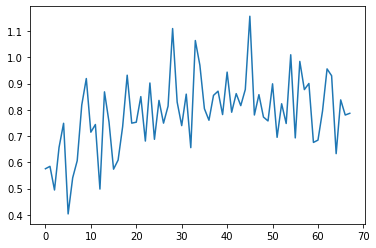

In [155]:
result_2 = trainIters(encoder1, attn_decoder1,len(data_train),1, hidden_size,print_every=100,learning_rate=1e-2)

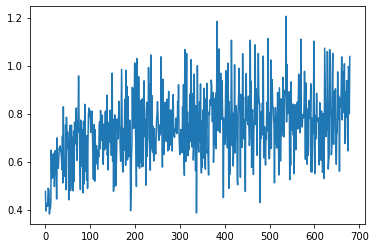

In [122]:
plt.plot(result_1)

In [158]:
sentence = '모델에 문제가 없으면 전처리에 집중해야한다.'
test = test_trans(encoder1, attn_decoder1, sentence,hidden_size)
print(test)

the killed civil ve  crash worthy It  cli mat . <sep>


In [159]:
sentence = ['오바마는 대통령이다.','시민들은 도시 속에 산다.','커피는 필요 없다.','일곱 명의 사망자가 발생했다.']
for sen in sentence:
  print(test_trans(encoder1, attn_decoder1, sen,hidden_size))

[ posing r project new in DNA flu crash at . <sep>
All <sep>
All <sep>
nominate . <sep>


BahdanauAttention 을 어떻게 구현하는 부분에서 막힘. 추후에 토론을 통해서 확인해야 하는 부분.   
차원 수를 맞추는데 힘듬.   
softmax 가 log 냐 그냥이냐에 따라 loss 값이 달라짐.   
패드를 추가하지 않으면 길이문제로 인해 batch size 를 늘릴 수 없음.   
코드가 지저분함. 정리할 필요가 있음.
max_len 및 vocab의 minfreq 조절 , lr 조절.  
모델에 문제가 없으면 전처리에 집중해야한다.
문장에 unk 가 많으면 unk만 출력하고, bos 를 넣으면 bos 만, lr 에 따라 the, is, a 만 출력하는 local minumum에 빠지기도 한다.  
학습이 잘 안되는 이유는 유효한 전처리과정을 몇개 빼먹은 것과 vocab 사이즈가 큰 것이 원인이라 보인다.(임베딩 레이어의 학습도 힘들어보임)(+ 그밖의 확인하지 못한 것들)

pytorch decoder 기존의 것도 같은 증상인 것으로 보아 전처리와 데이터의 차이로 보임. loss 를 낮추기 위해 관사와 기호를 출력하는것이 전처리에서 이들을 제거하는 방향으로 잡는 이유로 보임. 

토크나이저를 변경해도 결과는 비슷하게 나옴. 모델 및 하이퍼파라미터의 차이로 보임(잘못 짠 모델), 같은 토크나이저 로 트랜스포머를 실험할 예정.

LR 을 높여서 진행시 loss 가 줄어들지 않으며 LR 이 낮으면 위에 언급한 local minmum으로 수렴하게됨.(loss 가 낮아지지만 의미가 없음)

여기서 쓴 tokenizer는 bert 의 파인튜닝에 충분히 학습 가능한 유의미한 토크나이저라 할 수 있음.